### Recovering a hidden temperature field from hot/cold readings

Imagine a 2D grid of true temperatures `T[i, j]` over a surface. The sensors we have are simple: they only tell us whether a location is “hot” (1) or “cold” (0) relative to a threshold. We do not see temperatures directly. Our goal is to reconstruct the continuous temperature field from these binary observations by exploiting the fact that real temperatures vary smoothly across space.


### Generative model (intuition)

- **Latent field**: Continuous temperatures `T[i, j]` that are spatially smooth; neighbors tend to be similar.
- **Observations**: Binary hot/cold readings `y[i, j] ∈ {0,1}` with noise, modeled as `y[i, j] ~ Bernoulli(σ(T[i, j]))`, where `σ` is the logistic function. The threshold can be absorbed into the offset of `T`.
- **Spatial prior**: A pairwise coupling between neighbors that penalizes sharp jumps, encouraging smooth reconstructions unless data strongly suggests boundaries.

In this notebook, we implement the logistic observation via a custom `Sigmoid` node and enforce spatial smoothness using Gaussian couplings between neighboring cells (a Gaussian MRF–like prior).


### What this notebook does

- **Simulates observations**: Loads a smooth grayscale image as a proxy for `T` and produces noisy hot/cold readings via a logistic sensor.
- **Builds the model**: Combines a logistic observation (`Sigmoid`) with a spatial prior coupling neighbors.
- **Performs inference**: Uses variational message passing to approximate the posterior over `T`.
- **Visualizes results**: Compares the binary observations to the recovered continuous temperature field (normalized).


### Setup

Load the packages used for probabilistic modeling, image I/O, plotting, and numerical routines.


In [42]:
using Distributions, ExponentialFamilyProjection, Images, Plots, ReactiveMP, RxInfer, StableRNGs, StatsFuns

### Custom logistic observation factor

We introduce a ``Sigmoid`` factor that models the logistic link and provide variational rules needed by the optimizer. This lets us couple the binary observations to the continuous latent field.


In [43]:
struct Sigmoid end

@node Sigmoid Stochastic [out, x]

@rule Sigmoid(:x, Marginalisation) (q_out::PointMass,) = begin
    y = mean(q_out)
    y = float(mean(q_out))
    sign = 1-2y
    # Provide logpdf, gradient, and Hessian for 1D logistic-Bernoulli
    _logpdf = (out, x) -> (out[] = -softplus(sign * x))
    _grad = (out, x) -> (out[1] = y - logistic(x))
    _hess = (out, x) -> (out[1, 1] = -logistic(x) * (1 - logistic(x)))
    return ExponentialFamilyProjection.InplaceLogpdfGradHess(_logpdf, _grad, _hess)
end

function BayesBase.prod(::GenericProd, left::UnivariateGaussianDistributionsFamily, right::ExponentialFamilyProjection.InplaceLogpdfGradHess)
    m = mean(left)
    σ = var(left)
    combined_logpdf! = (out, x) -> begin
        right.logpdf!(out, x)
        out[] = logpdf(left, x) + out[]
    end
    combined_gradhes! = (out_grad, out_hess, x) -> begin
        out_grad, out_hess = right.grad_hess!(out_grad, out_hess, x)
        out_grad .= out_grad .- ((x .- m) ./ σ)
        out_hess .= out_hess .- 1 / σ
        return out_grad, out_hess
    end
    return ExponentialFamilyProjection.InplaceLogpdfGradHess(combined_logpdf!, combined_gradhes!)
end

function BayesBase.prod(::GenericProd, left::ExponentialFamilyProjection.InplaceLogpdfGradHess, right::UnivariateGaussianDistributionsFamily)
    return prod(GenericProd(), right, left)
end

### Data: proxy temperature field and binary observations

We load a smooth grayscale image as a stand-in for the true temperature field, normalize it, and generate noisy hot/cold readings by sampling from $$\mathrm{Bernoulli}(\sigma(T)).$$


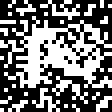

In [44]:
rng = StableRNG(112)
mnist_picture = load("mnist_picture.png")
mnist_picture

sample_matrix = convert(Matrix{Float64}, mnist_picture);
normalized_matrix = (sample_matrix .- mean(sample_matrix))/std(sample_matrix)

observation_matrix = begin 
    o = zeros(28, 28)
    for i in 1:28, j in 1:28
        o[i, j] = rand(rng, Bernoulli(logistic(normalized_matrix[i, j])))
    end
    o
end

Gray.(observation_matrix)

### Model and first inference run

- The model places a Gaussian prior with neighbor couplings on the latent field $$x[i,j]$$ and uses a logistic observation $$y \sim \mathrm{Bernoulli}(\sigma(x))$$ via the custom ``Sigmoid`` factor.
- We run variational inference and visualize three panels: normalized proxy field, binary observations, and the reconstructed field.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


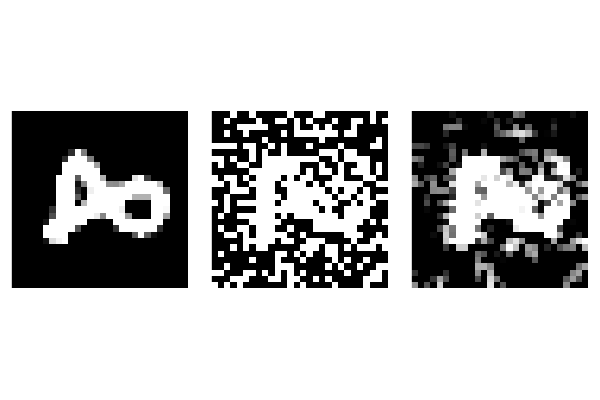

In [45]:
@model function sigmoid_ising(h, w, image, connection_force)
    # x_extra_prior ~ NormalMeanVariance(0, 1)
    local x
    # as smaller variance as closer the estimates
    var_used = 1.0/connection_force
    prior ~ NormalMeanVariance(0, var_used)
    for i in 1:h, j in 1:w
        x[i, j] ~ NormalMeanVariance(prior, var_used)
    end 
    for i in 1:h, j in 1:w
        image[i, j] ~ Sigmoid(x[i, j]) 
        if i < h && j < w
           x[i, j] ~ NormalMeanVariance(x[i+1, j], var_used)
           x[i, j] ~ NormalMeanVariance(x[i, j+1], var_used)
        end
        if i < h
            x[i, j] ~ NormalMeanVariance(x[i+1, j], var_used)
        end
        if j < w
            x[i, j] ~ NormalMeanVariance(x[i, j+1], var_used)
        end
    end
end

# Streaming init & autoupdates
sigmoid_init = @initialization begin
    q(x) = NormalMeanVariance(0.0, 1.0)
    q(prior) = NormalMeanVariance(0.5, 1)
end

binary_constraints = @constraints begin
    q(x) :: ProjectedTo(NormalMeanVariance, parameters = ProjectionParameters(
        tolerance = 1e-8,
        strategy = ExponentialFamilyProjection.GaussNewton(nsamples = 1), # deterministic
    ))
    q(x, prior) = q(x)q(prior)
    q(x) = MeanField()
    # q(x_prior, x, x_extra, x_extra_prior) = q(x_prior)q(x)q(x_extra, x_extra_prior)
end

result = infer(
    model          = sigmoid_ising(h=28, w=28, connection_force = 1), 
    data           = (image = observation_matrix,),
    returnvars     = KeepEach(),
    # options        = (limit_stack_depth = 100, ),
    iterations     = 5,
    initialization = sigmoid_init,
    constraints    = binary_constraints,
    showprogress   = true,
);

sigmoid_outputs = map(mean, result.posteriors[:x][5]);
normalize_sigmoid_outputs = (sigmoid_outputs .- mean(sigmoid_outputs))/std(sigmoid_outputs)

l = @layout [
    grid(1,3)
]
plot_obj = plot(layout=l)
plot!(plot_obj, Gray.(normalized_matrix), subplot=1, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
plot!(plot_obj, Gray.(observation_matrix), subplot=2, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
plot!(plot_obj, Gray.(normalize_sigmoid_outputs), subplot=3, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)


### Introduce missing observations

We simulate missing data by randomly masking a fraction of binary readings. Masked locations will be rendered in yellow in the visualization.


In [46]:
mask_probability = 0.25
masked_pattern = rand(rng, Bernoulli(mask_probability), size(observation_matrix)...) 

# Apply mask to observations as Union{Missing, Float64}
masked_observation_matrix = Matrix{Union{Missing, Float64}}(undef, size(observation_matrix)...)
@inbounds for j in axes(observation_matrix, 2), i in axes(observation_matrix, 1)
    masked_observation_matrix[i, j] = masked_pattern[i, j] ? missing : Float64(observation_matrix[i, j])
end

### Missing binary observations and the Monte Carlo message

When some binary outputs  y[i,j] in {0,1} are missing, we can still perform inference by passing an approximate message from the observation factor using the variational marginal over the latent field.

For the logistic observation model `y | x ~ Bernoulli(σ(x))`, the factor contribution is
$$ f(y \mid x) = \mathrm{Bernoulli}(y; \sigma(x)) = \sigma(x)^y (1-\sigma(x))^{1-y}. $$
The message needed by variational updates in many formulations is the expected log-factor under the current marginal `q(x)`:
$$ \mathbb{E}_{q(x)}[\log f(y \mid x)] = y\,\mathbb{E}_{q(x)}[\log \sigma(x)] + (1-y)\,\mathbb{E}_{q(x)}[\log(1-\sigma(x))] = \mu y + C. $$
Note that $$ \log \sigma(x) - \log(1-\sigma(x)) = x.$$

### Implement observation message for missing outputs

We add a simple rule for ``q(y)`` when needed: use the current mean of ``q(x)`` passed through the logistic to parameterize a Bernoulli. This provides a lightweight, consistent message for the missing-observation case.


In [47]:
@rule Sigmoid(:out, Marginalisation) (q_x::NormalMeanVariance, ) = begin
    return Bernoulli(logistic(mean(q_x)))
end

### Inference with missing observations

We now run the same model on the masked data. The observation message (previous cell) lets inference proceed for locations where ``y`` is missing.


In [48]:
result_masked = infer(
    model          = sigmoid_ising(h=28, w=28, connection_force=1), 
    data           = (image = masked_observation_matrix,),
    returnvars     = KeepEach(),
    # options        = (limit_stack_depth = 100, ),
    iterations     = 5,
    initialization = sigmoid_init,
    constraints    = binary_constraints,
    showprogress   = true,
);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


### Visualize masked observations and reconstruction

- Yellow pixels mark missing observations; gray pixels show observed hot/cold readings rendered as grayscale for context.
- We compare the original normalized proxy field, the binary observations, the unmasked reconstruction, the masked observation map, and the masked reconstruction.


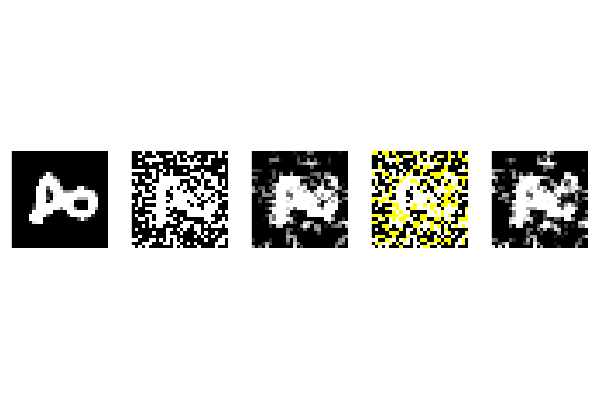

In [49]:
sigmoid_outputs_masked = map(mean, result_masked.posteriors[:x][5]);
normalize_masked_sigmoid_outputs = (sigmoid_outputs_masked .- mean(sigmoid_outputs_masked))/std(sigmoid_outputs_masked)

yellow = colorant"yellow"# Replace missings with 0 just to build the base gray image in RGB
masked_img = RGB.(Gray.(replace(masked_observation_matrix, missing => 0.0)))
masked_img[masked_pattern] .= yellow


plot_obj_masked = plot(layout=@layout [
    grid(1,5)
])
plot!(plot_obj_masked, Gray.(normalized_matrix), subplot=1, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
plot!(plot_obj_masked, Gray.(observation_matrix), subplot=2, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
plot!(plot_obj_masked, Gray.(normalize_sigmoid_outputs), subplot=3, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
plot!(plot_obj_masked, masked_img, subplot=4, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
plot!(plot_obj_masked, Gray.(normalize_masked_sigmoid_outputs), subplot=5, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)


### Sweep over connection_force and animate results

We will run inference for a range of `connection_force` values on both the original noised observations and the masked observations, and generate animations to visualize how the reconstruction changes.


In [50]:
exponents = collect(-10:2:10)
connection_forces = 10.0 .^ exponents
iterations_anim = 5

function run_reconstruction(image, connection_force; h=28, w=28, iterations=iterations_anim)
    result = infer(
        model          = sigmoid_ising(h=h, w=w, connection_force=connection_force),
        data           = (image = image,),
        returnvars     = KeepEach(),
        iterations     = iterations,
        initialization = sigmoid_init,
        constraints    = binary_constraints,
        showprogress   = false,
    )
    xs = map(mean, result.posteriors[:x][iterations])
    return (xs .- mean(xs)) / std(xs)
end
# helper for animation


run_reconstruction (generic function with 1 method)

┌ Info: Saved animation to /Users/mykola/repos/ReactiveBayes/RxInferExamples.jl/examples/Problem Specific/Ising Model/ising_connection_force_noised.gif
└ @ Plots /Users/mykola/.julia/packages/Plots/8ZnR3/src/animation.jl:156


Plots.AnimatedGif("/Users/mykola/repos/ReactiveBayes/RxInferExamples.jl/examples/Problem Specific/Ising Model/ising_connection_force_noised.gif")
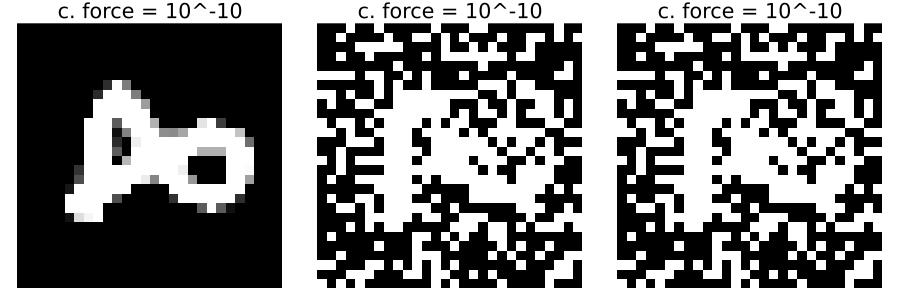

In [51]:
anim_noised = @animate for (idx, cf) in enumerate(connection_forces)
    k = exponents[idx]
    recon = run_reconstruction(observation_matrix, cf)
    l = @layout [grid(1,3)]
    plt = plot(layout=l, size=(900, 300), title="c. force = 10^$(k)")
    plot!(plt, Gray.(normalized_matrix), subplot=1, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
    plot!(plt, Gray.(observation_matrix), subplot=2, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
    plot!(plt, Gray.(recon), subplot=3, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
end

gif(anim_noised, "ising_connection_force_noised.gif", fps=1)


┌ Info: Saved animation to /Users/mykola/repos/ReactiveBayes/RxInferExamples.jl/examples/Problem Specific/Ising Model/ising_connection_force_masked.gif
└ @ Plots /Users/mykola/.julia/packages/Plots/8ZnR3/src/animation.jl:156


Plots.AnimatedGif("/Users/mykola/repos/ReactiveBayes/RxInferExamples.jl/examples/Problem Specific/Ising Model/ising_connection_force_masked.gif")
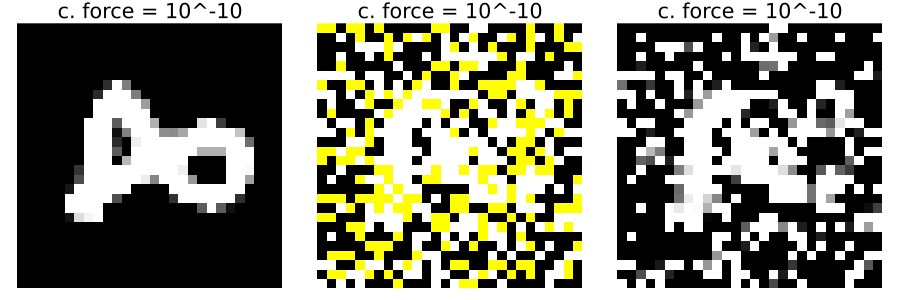

In [52]:
anim_masked = @animate for (idx, cf) in enumerate(connection_forces)
    k = exponents[idx]
    recon = run_reconstruction(masked_observation_matrix, cf)
    l = @layout [grid(1,3)]
    plt = plot(layout=l, size=(900, 300), title="c. force = 10^$(k)")
    plot!(plt, Gray.(normalized_matrix), subplot=1, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
    plot!(plt, masked_img, subplot=2, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
    plot!(plt, Gray.(recon), subplot=3, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
end

gif(anim_masked, "ising_connection_force_masked.gif", fps=1)


### Conclusion

- We reconstructed a smooth latent temperature field from binary hot/cold readings using a logistic observation model and a spatial (neighbor) prior.
- With missing observations, adding an approximate observation message allows inference to proceed; the reconstruction remains coherent where data is absent.
- The connection force is a very important hyperparameter in this model that controls the smoothing. If it's too small, no recovery is possible—the model just follows the data. If it's too strong, it can overpower the data completely.